# **Market Basket Analysis Project**

## **Project Overview**
Market Basket Analysis (MBA) is a popular data mining technique used to identify associations or patterns between items in transactional data. The goal of this project is to uncover valuable insights into customer purchasing behavior using **frequent itemset mining** and **association rule mining**.

### **Objectives:**
- Perform exploratory data analysis (EDA) to understand the structure and characteristics of the dataset.
- Apply **FP-Growth** to find frequent itemsets and generate association rules.
- Extract actionable insights to improve **merchandising strategies**, such as product bundling and cross-selling.

### **Dataset Description:**
- **Transactions**: The dataset contains customer transactions from a retail store. Each transaction includes a unique identifier, a list of purchased items, and additional details.
- **Features**:
  - `BillNo`: Unique identifier for each transaction.
  - `Itemname`: Description of purchased items.
  - `Date`: Date of purchase.
  - `CustomerID`: Anonymized customer identifier.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Standard Library Imports
import os
import zipfile
import datetime as dt
from warnings import filterwarnings

# Data Processing
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Frequent Pattern Mining
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_path = "/content/drive/My Drive/Colab Notebooks/MBA_AS/mba_data.zip"
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Load dataset
csv_path_train = os.path.join(extract_path, "Assignment-1_Data.csv")
df = pd.read_csv(csv_path_train, delimiter=';')
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,01.12.2010 08:26,"2,55",17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,01.12.2010 08:26,"2,75",17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,01.12.2010 08:26,"3,39",17850.0,United Kingdom


# **Exploratory Data Analysis and Data Cleaning**

## **Overview of the Dataset**
We begin by examining the dataset to check for missing values, duplicates, and inconsistencies. The key focus is on understanding the distribution of transactions and identifying frequent items.

### **Key Tasks:**
- Check for missing values and duplicates.
- Standardize item descriptions (e.g., remove extra spaces, convert to lowercase).
- Aggregate transactions by `BillNo` to create itemsets for each transaction.

## **Frequency Analysis**
The frequency of each item is calculated to identify the most popular products. This helps determine which items are frequently purchased together.





In [3]:
# Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      522064 non-null  object 
 1   Itemname    520609 non-null  object 
 2   Quantity    522064 non-null  int64  
 3   Date        522064 non-null  object 
 4   Price       522064 non-null  object 
 5   CustomerID  388023 non-null  float64
 6   Country     522064 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 27.9+ MB


In [4]:
# Check for missing values
df.isnull().sum()

,0
BillNo,0
Itemname,1455
Quantity,0
Date,0
Price,0
CustomerID,134041
Country,0


In [5]:
# Fill missing CustomerID with 'Unknown'
df['CustomerID'].fillna('Unknown', inplace=True)

# Drop rows with missing Itemname
df_cleaned = df.dropna(subset=['Itemname'])

In [6]:
# Check and remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['BillNo', 'Itemname', 'Date'])
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'], errors='coerce')

# Print date range
min_date = df_cleaned['Date'].min()
max_date = df_cleaned['Date'].max()
print(f"Date range in the dataset: {min_date} to {max_date}")

Date range in the dataset: 2010-01-12 08:26:00 to 2011-12-10 17:19:00


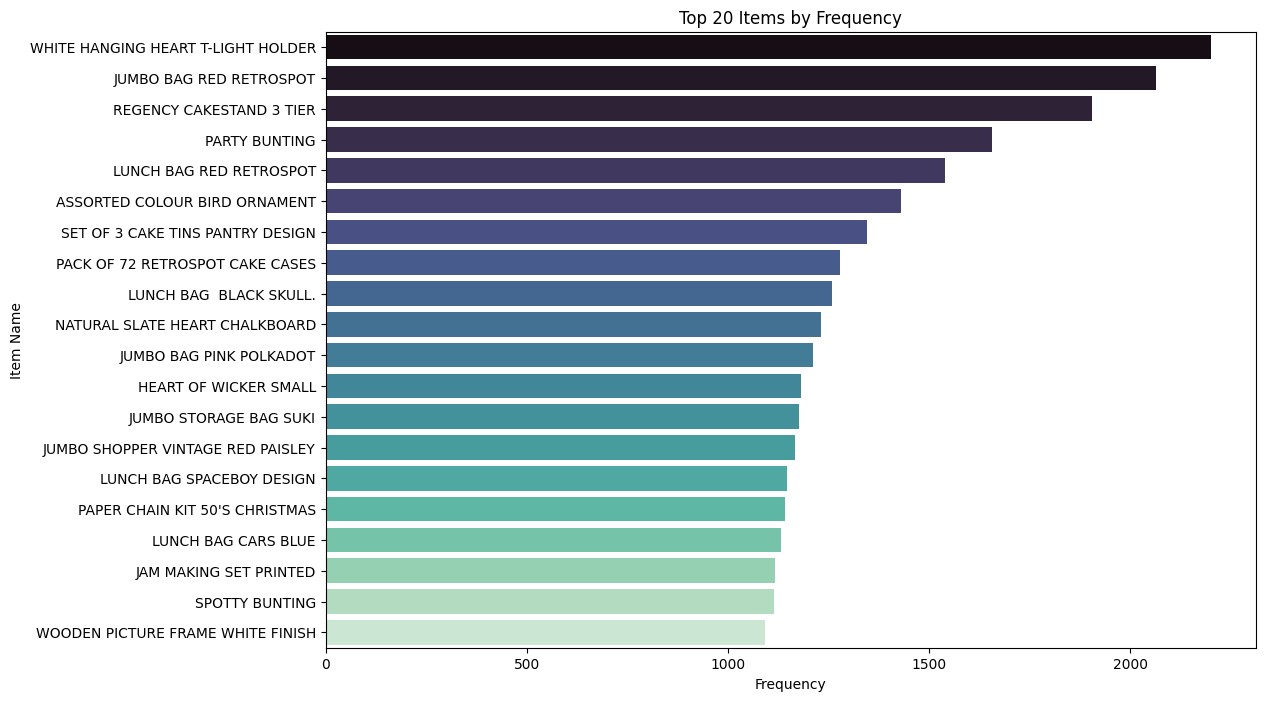

In [7]:
# Calculate item frequency
df_agg_items = df_cleaned.groupby('Itemname').size().reset_index(name='Frequency')
df_agg_items = df_agg_items.sort_values(by='Frequency', ascending=False)

# Plot top 20 items by frequency
plt.figure(figsize=(12, 8))
top_items = df_agg_items.head(20)
sns.barplot(x='Frequency', y='Itemname', data=top_items, palette='mako')
plt.title('Top 20 Items by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Item Name')
plt.show()

In [8]:
# Analyze the number of items per transaction
df_agg_purchases = (
    df_cleaned
    .groupby('BillNo')
    .agg(nu_items=('Itemname', 'count'))
    .reset_index()
    .sort_values(by='nu_items', ascending=False)
)

df_agg_purchases.describe(percentiles=[.01, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99]).T

,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
nu_items,20210.0,25.226917,46.743551,1.0,1.0,1.0,1.0,4.0,7.0,11.0,15.0,19.0,24.0,33.0,51.0,74.0,217.0,1108.0


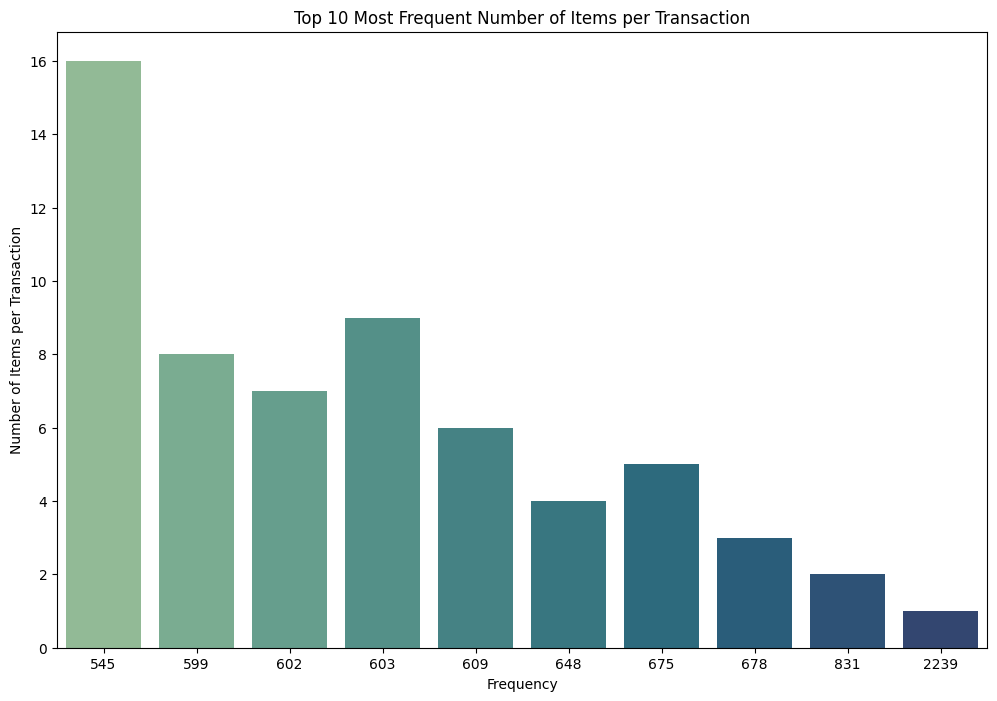

In [9]:
# Plot distribution of items per transaction
plt.figure(figsize=(12, 8))
top_frequencies = df_agg_purchases['nu_items'].value_counts().head(10).sort_index()
sns.barplot(x=top_frequencies.values, y=top_frequencies.index, palette='crest')
plt.title('Top 10 Most Frequent Number of Items per Transaction')
plt.xlabel('Frequency')
plt.ylabel('Number of Items per Transaction')
plt.show()

# **Data Transformation**

## **Grouping and Encoding Transactions**
To apply frequent itemset mining, we transform the data into a format where each row represents a transaction and contains the list of items purchased.

### **Transaction Encoding:**
We use `TransactionEncoder` to convert the transactions into a binary matrix, where:
- **1** indicates the presence of an item in a transaction.
- **0** indicates the absence of an item.

This transformation is necessary to apply the **FP-Growth** algorithm for frequent itemset mining.


In [10]:
# Data Cleaning
df_cleaned['Itemname'] = df_cleaned['Itemname'].str.strip().str.lower()

In [11]:
# Group Transactions
df_grouped = (
    df_cleaned
    .groupby('BillNo')['Itemname']
    .apply(list)
    .reset_index()
)
df_grouped.columns = ['BillNo', 'Items']

# Ensure transactions are properly formatted
df_grouped['Items'] = df_grouped['Items'].apply(lambda x: [item.strip().lower() for item in x])
df_grouped = df_grouped[df_grouped['Items'].apply(len) > 0]

In [12]:
# Encode Transactions
transactions = df_grouped['Items'].tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head()

,*boombox ipod classic,*usb office mirror ball,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 hanging eggs hand painted,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# **Algorithm: Frequent Pattern Growth (FP-Growth)**

## **Why FP-Growth?**
- **FP-Growth** is a faster and more efficient alternative to the Apriori algorithm for frequent itemset mining.
- It uses a compressed representation called an **FP-tree**, which reduces the time complexity for discovering frequent itemsets.

## **Parameters:**
- **Minimum Support (`min_support`)**: The minimum proportion of transactions that must contain an itemset for it to be considered frequent. We set `min_support = 0.01` to focus on meaningful itemsets.
- **Itemset Length**: Itemsets with at least two items are retained for further analysis.


In [13]:
# Generate Frequent Itemsets
MIN_SUPPORT = 0.01
frequent_itemsets = fpgrowth(df_encoded, min_support=MIN_SUPPORT, use_colnames=True)

# Convert itemsets to tuple format
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: tuple(sorted(x)))

# **Association Rule Mining**

## **Overview**
Association rule mining identifies relationships between items in frequent itemsets. For each rule of the form **A → B**, we calculate:
- **Support**: The proportion of transactions containing both A and B.
- **Confidence**: The likelihood that B is purchased given that A is purchased.
- **Lift**: How much more likely B is to be purchased when A is purchased compared to random chance.

### **Parameters:**
- **Metric**: We use `lift` to prioritize rules with the strongest associations.
- **Minimum Thresholds**: We set `min_threshold = 1` for lift to avoid weak associations.

## **Filtering and Displaying Top Rules**
The final step is to filter the association rules based on confidence, lift, and support, then visualize and analyze the top 10 rules.


In [14]:
# Generate Association Rules
ASSOCIATION_RULES_METRIC = "lift"
ASSOCIATION_RULES_MIN_THRESHOLD = 1

df_rules = association_rules(
    frequent_itemsets,
    metric=ASSOCIATION_RULES_METRIC,
    min_threshold=ASSOCIATION_RULES_MIN_THRESHOLD
)

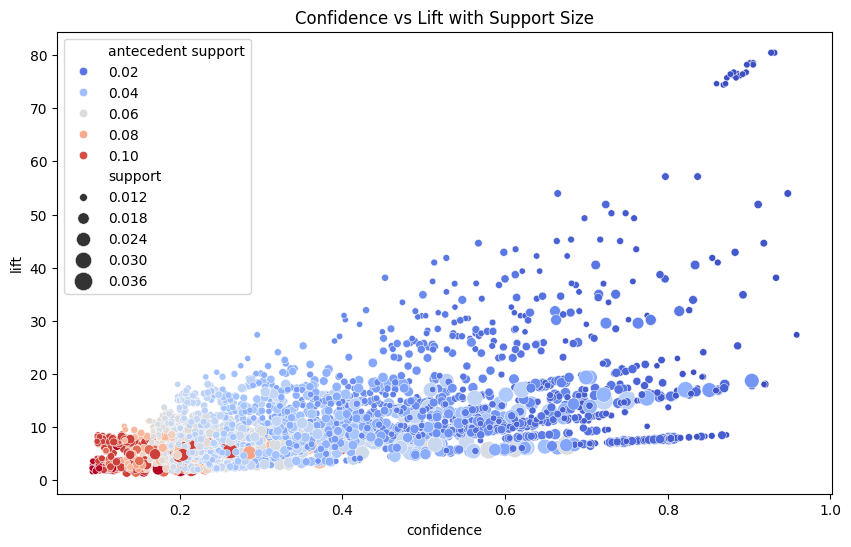

In [15]:
# Visualization & Insights
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_rules,
    x="confidence",
    y="lift",
    size="support",
    hue="antecedent support",
    palette="coolwarm",
    sizes=(20, 200)
)
plt.title("Confidence vs Lift with Support Size")
plt.show()

In [16]:
# Filter & Display Top Rules
filtered_rules = df_rules[
    (df_rules['confidence'] > 0.6) &
    (df_rules['lift'] > 10) &
    (df_rules['lift'] < 50) &  # New Condition: Remove extreme lift values
    (df_rules['support'] > 0.01)
]

# Rank by confidence and lift, then select the top 10
top_rules = filtered_rules.sort_values(['confidence', 'lift'], ascending=False).head(10)

# Display the top 10 rules with formatted output
print("Top 10 Association Rules:\n")
for idx, row in top_rules.iterrows():
    antecedent = ', '.join(row['antecedents'])
    consequent = ', '.join(row['consequents'])
    print(f"Antecedent: {antecedent} → Consequent: {consequent}")
    print(f"  - Confidence: {row['confidence']:.2f}, Lift: {row['lift']:.2f}, Support: {row['support']:.4f}\n")

Top 10 Association Rules:

Antecedent: suki  shoulder bag, jam making set printed → Consequent: dotcom postage
  - Confidence: 0.96, Lift: 27.37, Support: 0.0103

Antecedent: wooden heart christmas scandinavian, wooden tree christmas scandinavian → Consequent: wooden star christmas scandinavian
  - Confidence: 0.93, Lift: 38.11, Support: 0.0111

Antecedent: woodland charlotte bag, charlotte bag pink polkadot, strawberry charlotte bag → Consequent: red retrospot charlotte bag
  - Confidence: 0.92, Lift: 18.08, Support: 0.0119

Antecedent: charlotte bag suki design, woodland charlotte bag, charlotte bag pink polkadot, strawberry charlotte bag → Consequent: red retrospot charlotte bag
  - Confidence: 0.92, Lift: 18.06, Support: 0.0100

Antecedent: regency tea plate green, regency tea plate pink → Consequent: regency tea plate roses
  - Confidence: 0.92, Lift: 44.61, Support: 0.0117

Antecedent: regency cakestand 3 tier, roses regency teacup and saucer, pink regency teacup and saucer → Con

# **Insights and Recommendations**

## **Key Findings**
1. **Regency Tea Plates and Teacups:** Strong co-purchase patterns among different colors and styles.
2. **Charlotte Bags:** Consistent cross-selling of multiple bag designs.
3. **Seasonal and Themed Items:** Customers often complete sets of Christmas Scandinavian decorations.
4. **Dotcom Postage:** Frequently purchased alongside specific items, indicating these are likely online orders.

## **Recommendations:**
- **Product Bundling:** Create promotional bundles for commonly purchased items (e.g., Regency tea sets or Charlotte bag collections).
- **Cross-Selling Opportunities:** Recommend complementary items at checkout.
- **Themed Promotions:** Offer discounts on themed items to encourage customers to complete their collections.

